# Extracting timing and identity of sounds (FM oddball paradigm) 

Given the data saved by Spike2 during an oddball paradigm session with FM up and down sweeps, this notebook shows how to extract:
1. An array with the onset of each sound presented.
2. The identity of each sound (up vs down sweep).

In [65]:
import os
import numpy as np
import scipy.io
import h5py
import matplotlib.pyplot as plt

Let's define a few functions we will use:

In [66]:
def find_onsets(signal, signalThreshold=0.1, periodThreshold=100000):
    """
    Detect onsets in a signal based on an amplitude threshold and  aminimum period.

    Args:
        signal (numpy.ndarray): The input signal.
        signalThreshold (float, optional): The amplitude threshold for detecting onsets.
            Defaults to 0.1.
        periodThreshold (int, optional): The minimum period between consecutive onsets.
            Defaults to 100000.

    Returns:
        numpy.ndarray: An array containing the indices of detected onsets in the input signal.
    """
    signalDiff = np.diff(signal, prepend=signal[0])
    signalOnset = signalDiff > signalThreshold
    onsetIndsAll = np.flatnonzero(signalOnset)
    onsetDiff = np.diff(onsetIndsAll, prepend=periodThreshold)
    repeatedOnsets = onsetDiff < periodThreshold
    onsetInds = onsetIndsAll[~repeatedOnsets]
    return onsetInds

In [67]:
def find_fm_direction(sound, onsetInds, soundDurationInSamples=5000):
    """
    Determine the frequency modulation direction in sound samples around onset indices.

    Args:
        sound (numpy.ndarray): The sound waveform.
        onsetInds (numpy.ndarray): Array of onset indices in the sound waveform.
        soundDurationInSamples (int, optional): Duration of the sound after each onset.
            Defaults to 5000.

    Returns:
       numpy.ndarray: Array of integers indicating the frequency modulation direction.
       dict: Dictionary mapping labels ('up', 'down') to the integer values (0, 1).
    """
    nTrials = len(onsetInds)
    sweepDirectionLabels = {'up':0, 'down':1}  # Define the meaning of zeros and ones
    sweepDirection = np.zeros(nTrials, dtype=int)
    for indTrial in range(nTrials):
        soundFirstHalf = sound[onsetInds[indTrial]:
                               onsetInds[indTrial]+soundDurationInSamples//2]
        soundSecondHalf = sound[onsetInds[indTrial]+soundDurationInSamples//2:
                                onsetInds[indTrial]+soundDurationInSamples]
        freqFirstHalf = abs(np.fft.rfft(soundFirstHalf)).argmax()
        freqSecondHalf = abs(np.fft.rfft(soundSecondHalf)).argmax()
        if freqFirstHalf>freqSecondHalf:
            sweepDirection[indTrial] = sweepDirectionLabels['down']
        else:
            sweepDirection[indTrial] = sweepDirectionLabels['up']
    return sweepDirection, sweepDirectionLabels

## Read the data

In [68]:
# Define you data path here
dataPath = '/data/mesoscope/6998_231122_E295/fm_3_pre_doi/'
filename = 'Aud_3.mat'

h5file = h5py.File(os.path.join(dataPath, filename))
soundWaveform = np.array(h5file['sound']['values']).squeeze()

## Estimate the onset of each trial

In [69]:
signalThreshold = 0.1  # Amplitude threshold to detect the presence of a sound 
periodThreshold = 100000  # Minimum number of samples bewteen trials
onsetInds = find_onsets(soundWaveform, signalThreshold, periodThreshold)

Let's look at the first 8 onsets:

In [70]:
print(onsetInds[:8])

[ 227661  375547  525531  675532  825517  975527 1125525 1275558]


Let's check that it worked by plotting the signal and red lines indicating the sound onset:

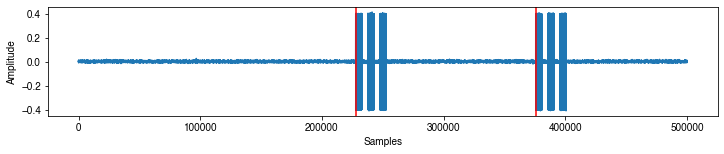

In [71]:
plt.figure(figsize=(12,2))
plt.plot(signal[0:500000]);
plt.ylabel('Amplitude')
plt.xlabel('Samples')
for oneOnset in onsetInds[:2]:
    plt.axvline(oneOnset, color='r')

## Find the identify of each sound (FM up or down)

In [72]:
soundDurationInSamples = 5000
sweepDirection, sweepDirectionLabels = find_fm_direction(sound, onsetInds, soundDurationInSamples=5000)

We now have an array of zeros and ones indicating sweep direction and an array of strings telling us the meaning of one or zero.

In [73]:
print(sweepDirection)

[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0]


# Save the results

In [74]:
outputFilename = 'soundID.npz'
np.savez(os.path.join(dataPath, outputFilename), onsetInds=onsetInds,
         sweepDirection=sweepDirection, sweepDirectionLabels=sweepDirectionLabels)